# Import Required Libraries
Import the necessary libraries, including PyTorch, torchvision, and matplotlib.

In [1]:
# Import Required Libraries
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

# Load the Model Checkpoint
Load the model from the checkpoint file using torch.load() and set the model to evaluation mode.

In [2]:
model_checkpoint_path = r'model_weights\TrDBNet_swin_base_2025-02-01_01-10-00.pth'

In [3]:

# Load the Model Checkpoint
from models import TrDBNet

# Assume the model architecture is defined elsewhere and matches the checkpoint
model = TrDBNet(variant='base')

# Load the state dictionary into the model
model.load_state_dict(torch.load(model_checkpoint_path))

# Set the model to evaluation mode
model.eval()

pass

d:\MT23MCS002\Miniconda\envs\TD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Aarya\AppData\Local\Temp\ipykernel_10616\474715231.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend y

# Prepare the Data
Prepare the data for inference, including any necessary transformations.

In [4]:
input_dir = "datasets\\Total Text\\totaltext\\Images\\Test"
target_dir = "datasets\\Total Text\\groundtruth_textregion\\Text_Region_Mask\\Test"

In [5]:
import os

input_images_list = os.listdir(input_dir)
target_images_list = os.listdir(target_dir)

In [6]:
input_image_name = input_images_list[95].split(".")[0]

input_image = Image.open(os.path.join(input_dir, input_image_name + ".jpg"))
target_image = Image.open(os.path.join(target_dir, input_image_name + ".png"))

In [7]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

input_tensor = transform(input_image)[None, :, :, :]
target_tensor = transform(target_image)

# Inference the Model
Run the model on the prepared data to generate the output images.

In [8]:
# Perform inference
with torch.no_grad():

    model.eval()

    prob_map, thresh_map, binary_map = model(input_tensor)
    

# Display Generated Images
Use matplotlib to display all the images generated by the model.

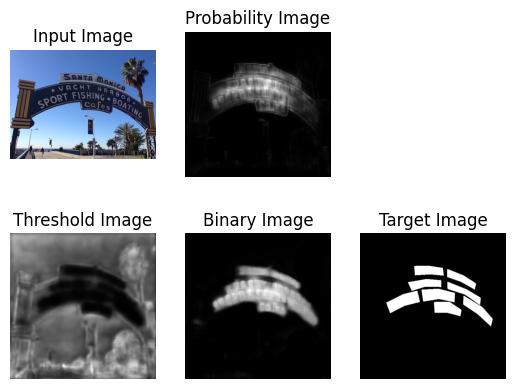

In [9]:
# Perform inference
with torch.no_grad():

    model.eval()

    prob_map, thresh_map, binary_map = model(input_tensor)
    
    input_img = input_tensor[0].cpu().numpy()
    target_img = target_tensor.cpu().numpy().reshape((512, 512, 1))

    prob_image = prob_map.squeeze().detach().cpu().numpy().reshape((512, 512, 1))
    thresh_image = thresh_map.squeeze().detach().cpu().numpy().reshape((512, 512, 1))
    binary_image = binary_map.squeeze().detach().cpu().numpy().reshape((512, 512, 1))

    fig, ax = plt.subplots(2, 3)

    ax[0][0].imshow(input_image)
    ax[0][0].set_title('Input Image')
    ax[0][0].axis('off')

    ax[0][1].imshow(prob_image, cmap = 'gray')
    ax[0][1].set_title('Probability Image')
    ax[0][1].axis('off')

    ax[1][0].imshow(thresh_image, cmap = 'gray')
    ax[1][0].set_title('Threshold Image')
    ax[1][0].axis('off')

    ax[1][1].imshow(binary_image, cmap = 'gray')
    ax[1][1].set_title('Binary Image')
    ax[1][1].axis('off')

    ax[1][2].imshow(target_img, cmap = 'gray')
    ax[1][2].set_title('Target Image')
    ax[1][2].axis('off')

    ax[0][2].axis('off')

    plt.show()

In [10]:
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

from dataset.TotalText import TotalText
from torch.utils.data import DataLoader

from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming you have a test dataset and DataLoader
test_dataset = TotalText(train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

model.to(device)
model.eval()  # Set the model to evaluation mode

all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in tqdm(test_loader):
        images, masks = images.to(device), masks.to(device)

        prob_map, thresh_map, binary_map = model(images)

        preds = binary_map.cpu().numpy().reshape(-1)
        targets = masks.cpu().numpy().reshape(-1)

        all_preds.extend(preds.tolist())
        all_targets.extend(targets.tolist())

# Convert lists to numpy arrays
all_preds = np.array(all_preds, dtype=np.float32)
all_targets = np.array(all_targets, dtype=np.float32)


100%|██████████| 38/38 [00:43<00:00,  1.16s/it]


In [11]:
all_preds = np.where(all_preds > 0.5, 1, 0)
all_targets = np.where(all_targets > 0.5, 1, 0)

In [12]:
# Calculate precision, recall, F-score, and mIoU
precision = precision_score(all_targets, all_preds)
recall = recall_score(all_targets, all_preds)
fscore = f1_score(all_targets, all_preds)
miou = jaccard_score(all_targets, all_preds)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F-score: {fscore}")
print(f"mIoU: {miou}")

Precision: 0.7594727842339563
Recall: 0.49698348091979905
F-score: 0.6008094964232666
mIoU: 0.4293979232187646
